# TF-IDF Clustering on kleister-charity dataset

## Import modules

In [217]:
import pandas as pd                                                       # dataframes lib
import numpy as np                                                        # linear algebra lib
import re                                                                 # regex lib
import matplotlib.pyplot as plt                                           # plotting lib 
from sklearn.decomposition import PCA, TruncatedSVD                       # dimensionality reduction module
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering       # sklearn clustering algorithms
from sklearn.feature_extraction.text import TfidfVectorizer               # tf-idf lib for text
from sklearn.metrics import adjusted_rand_score, silhouette_score         # evaluating clustering
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer   # NLTK tokenization modules
from nltk.corpus import stopwords                                         # NLTK stop words  
from nltk.stem.wordnet import WordNetLemmatizer                           # NLTK lemmitization lib
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')


## Data exploration and preprocessing

In [213]:
# read kleister test tsv file into dataframe
kleister = pd.read_csv('/home/becode/AI/Data/Faktion/kleister-charity/test-A/in.tsv', sep='\t',
                       names=['filename', 'keys', 'text_djvu', 'text_tesseract', 'text_textract', 'text_best'])
print(kleister.shape)
kleister = kleister.dropna() # drop nans
print(kleister.shape)

# keep only 'text_tesseract' OCR text column
kleister =kleister.drop(columns=['keys', 'text_djvu','text_textract','text_best'])

# some easy preprocessing after looking at text content
kleister['text_tesseract'] = kleister['text_tesseract'].astype(str)
kleister['text_tesseract'] = kleister['text_tesseract'].apply(lambda x: x.replace("\n",""))
kleister['text_tesseract'] = kleister['text_tesseract'].apply(lambda x: x.replace("\\n",""))

(609, 6)
(592, 6)


In [ ]:
# checking text content after removing '\n' and '\\n'

# print(f"\n{kleister['text_tesseract'][0]}")
# print(f"\n{kleister['text_tesseract'][100]}")
# print(f"\n{kleister['text_tesseract'][300]}")

## Tokenization and lemmitization func

In [218]:
# define function to tokenize and lemmatize sentences/words per document
def tokenize_lem(text):
    stop_words = set(stopwords.words('english'))
    lem = WordNetLemmatizer()
    # stem = PorterStemmer() Not used => Lem is better
    
    # first tokenize by sentence, then by word
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.match('[a-zA-Z]', token) and not token in stop_words and len(token)>3:
            lemmatized_word = lem.lemmatize(token)#, 'v')
            filtered_tokens.append(lemmatized_word)
            # stemmed = stem.stem(token)
            # filtered_tokens.append(stemmed)
    return filtered_tokens

In [ ]:
# checking text content after running tokenize_lem => will be called when running TF-IDF

# kleister['text_tesseract'] = kleister['text_tesseract'].apply(tokenize_lem)
# print(f"\n{kleister['text_tesseract'][0]}")
# print(f"\n{kleister['text_tesseract'][100]}")
# print(f"\n{kleister['text_tesseract'][300]}")

## TF-IDF vectorization

In [219]:
# Text needs to be vectorised for clustering, here we will use tf-idf

# Call vectorizer and params -> point to 'tokenize_lem' func which tokenizes, lemmatizes and removes stop words
tfidf_vectorizer = TfidfVectorizer(max_df= 0.8, min_df= 0,max_features=50000, stop_words=None,
                                   use_idf=True, tokenizer=tokenize_lem) #, ngram_range=(1,3))
# fit vectorizer and transform documents' text content to vectors
X = tfidf_vectorizer.fit_transform(kleister['text_tesseract']) 

print(X.shape)
print(X.toarray())
df1 = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())
print(df1)

print(tfidf_vectorizer.vocabulary_)
print(len(tfidf_vectorizer.vocabulary_))

(592, 50000)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.00655205 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
     a'rcelfyddydau  a'true  a-level  a-levels  a-levelstudents  a.c.  a.g.m  \
0               0.0     0.0      0.0       0.0              0.0   0.0    0.0   
1               0.0     0.0      0.0       0.0              0.0   0.0    0.0   
2               0.0     0.0      0.0       0.0              0.0   0.0    0.0   
3               0.0     0.0      0.0       0.0              0.0   0.0    0.0   
4               0.0     0.0      0.0       0.0              0.0   0.0    0.0   
..              ...     ...      ...       ...              ...

## Find number clusters for KMeans algo

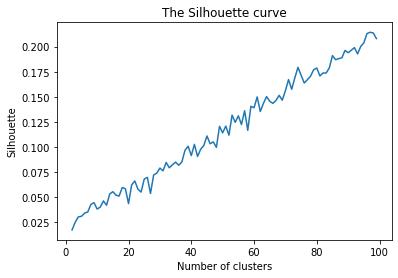

In [220]:
# Silhouette curve: silhouette score vs number clusters k (better metric than Elbow method)
n_clusters=100
sil_scores=[]
for i in range(2,n_clusters):
    kmeans = KMeans(i)
    labels = kmeans.fit_predict(X) # or kmeans.labels_ is the same
    sil_scores.append(silhouette_score(X,labels))
plt.plot(range(2,100),sil_scores)
plt.title('The Silhouette curve')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.show()

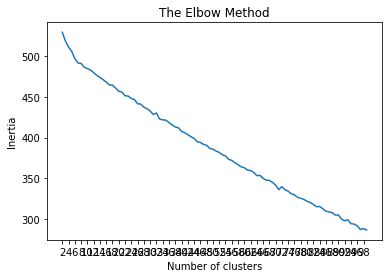

In [207]:
# Elbow curve: inertia(SSE) vs number clusters k
n_clusters=100
cost=[]
for i in range(2,n_clusters):
    kmeans= KMeans(i)
    kmeans.fit(X)
    cost.append(kmeans.inertia_)
plt.plot(range(2,100),cost)
plt.xticks(range(2,100,2))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



## in progress - try vectorizing with more restricted params as to get smaller vector space

In [145]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df= 0.8, min_df= 0.2,max_features=10000, stop_words=None,use_idf=True, tokenizer=tokenize_lem)#, ngram_range=(1,3))
X = tfidf_vectorizer.fit_transform(kleister['text_tesseract']) #fit the vectorizer

print(X.toarray())
df1 = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())
print(df1)

print(X.shape)
#print(tfidf_vectorizer.vocabulary_)
#print(len(tfidf_vectorizer.vocabulary_))

[[0.00633523 0.0056753  0.05764322 ... 0.         0.00637589 0.01138449]
 [0.00929066 0.02774292 0.08670176 ... 0.         0.         0.01484039]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01698566 0.01521631 0.         ... 0.         0.17094675 0.00678299]
 [0.03378682 0.         0.         ... 0.         0.         0.16190758]
 [0.02390897 0.03748226 0.         ... 0.00769731 0.01203121 0.        ]]
      ability      able  academic    accept  accepted    access  \
0    0.006335  0.005675  0.057643  0.003352  0.008066  0.013203   
1    0.009291  0.027743  0.086702  0.006555  0.007886  0.032269   
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.038459  0.000000  0.053836  0.000000  0.000000  0.000000   
4    0.000000  0.021159  0.000000  0.000000  0.000000  0.016407   
..        ...       ...       ...       ...       ...       ...   
587  0.000000  0.080248  0.000000  0.000000  0.000000  0.000000   
588  0.006251  0.061

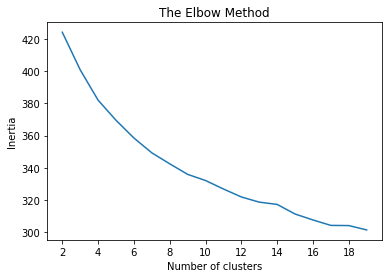

In [90]:
# Elbow curve : inertia vs k
n_clusters=20
cost=[]
for i in range(2,n_clusters):
    kmeans= KMeans(i)
    kmeans.fit(tfidf_matrix)
    cost.append(kmeans.inertia_)
plt.plot(range(2,20),cost)
plt.xticks(range(2,20,2))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


## KMeans clustering

In [ ]:
kmeans = KMeans(n_clusters=100, init='k-means++',n_init=10, max_iter=300, random_state=123)
kmeans.fit(X_reduced)
y=kmeans.predict(X_reduced)
print(y)
print(f"labels: {kmeans.labels_}") # y and kmeans.labels_ is same
clusters = kmeans.labels_.tolist()
print(clusters)
print(f"silhouette score = {silhouette_score(tfidf_matrix ,kmeans.labels_)}")
kleister['cluster'] = clusters
print(kleister['cluster'].value_counts())
kl = kleister.groupby('cluster')
print(kl)

## DBSCAN clustering

In [200]:
dbscan = DBSCAN(eps=0.85, min_samples=2)
dbscan.fit_predict(X)
print(dbscan.labels_)
print(f"silhouette score = {silhouette_score(X, dbscan.labels_)}")

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15   8  16
  17  -1  18  19  20  21  22  23  24  25   8  26  27  28  29  30  31  -1
  32  33  34  -1  35  36  -1  37  38  -1  39   8  40  41  42  43  44  45
  25  46  47  48  49  50  24  51   8  22  52  53   2  54  55  56  57  58
  59  60  61  62  63  61  -1  64  65  61  66  60  67  68  69  70  71  72
  73  74   8  75  76  77  53  78  79  17  80  81   8  61   8  82  83  84
  85   1  86  87  -1  -1  -1  88  89  -1  90   8  91  92  42  72  93  94
  95  96  97  -1  98  99 100  47 101  -1 102 103   8  42  23 104 105 106
 107   1 108 109 110 111  -1  -1  -1 112 113 114 115 116 117 118  -1 119
  75 120 121 122 123   7 124 121 125  -1 126 127  -1 128  -1 129 130 119
 123 131 132 133 134 135  -1 118 129 136 137 138 139  -1 140 141 142  50
 143 144 145 146 147 148  -1 137 149  56 150  33   8  18 151 152 153 154
  56 155 118 156   1  -1  85 157 158 159  39  45 160 161 162  -1  -1 163
 103  51 164  17 165 166 167  -1 110  42 168  -1 16

In [201]:
# cluster per file
dblab = pd.DataFrame({'cluster' : dbscan.labels_})
print(dblab)

     cluster
0          0
1          1
2          2
3          3
4          4
..       ...
587       -1
588      115
589      179
590       -1
591      177

[592 rows x 1 columns]


In [202]:
print(dblab[dblab.cluster == -1]) # outliers

     cluster
19        -1
35        -1
39        -1
42        -1
45        -1
..       ...
561       -1
582       -1
584       -1
587       -1
590       -1

[111 rows x 1 columns]


In [203]:
print(dblab[dblab.cluster == -1].count()) # number of outliers

cluster    111
dtype: int64


In [204]:
print(dblab.cluster.value_counts()) # files per cluster

-1      111
 8       28
 42       9
 1        7
 61       5
       ... 
 90       2
 91       2
 92       2
 185      2
 0        2
Name: cluster, Length: 187, dtype: int64


In [205]:
print(len(dblab.cluster.unique())) # number of clusters

187


In [192]:
kleister['cluster'] = dblab['cluster'].astype(str)
print(kleister.head(25))

                                filename  \
0   abbf98ed31e28068150dce58296302ee.pdf   
1   f3e363848aea2fa645814f2de0221a5a.pdf   
2   62acdd1bbd0dfeea27da2720eb795449.pdf   
3   e734bc7dfc9b37c5dd2c3a37693062e8.pdf   
4   cb6b0949a2f9294750e436f7ea2f10ce.pdf   
5   87c977ccb9bdf111b1397e9c4ada2470.pdf   
6   39df988309a04c631445b04ebd6a4a53.pdf   
7   e38bd1524e145b49edf991ab8f3e153d.pdf   
8   bb80583ada5875ccb4690ffa22f97bab.pdf   
9   7ae3665305caf119acabb0863ea1e46d.pdf   
10  dfe49a61d083ec665db91184150d1f51.pdf   
11  d407188b117523da08f8410e392fb2a5.pdf   
12  1fb9abd2c01f71c34d1de0106858ae57.pdf   
13  2a1e0d3371835da70449eca9a93df0cf.pdf   
14  e0034978b59a53c6f607c8ac9d04fe9e.pdf   
15  5ca7d4dbb023922f49e741d81821b689.pdf   
16  6332f7cf09190bf30752c947a0a686fd.pdf   
17  6c6254ab7171b47e41cce228253b9063.pdf   
19  a5c40991580e19fa0effc99c3bb70eed.pdf   
20  e0a0aba889bb94a69d90e74127d9c2d9.pdf   
21  2c15c83ae6bafc13ed2b5e434e603a37.pdf   
22  e2cabb3dfb4192d0d913611b6828

In [83]:
#kleister['filename']= kleister['filename'].apply(lambda x :)
check = kleister.drop(['text_tesseract'], axis=1)
print(check.head())

                               filename cluster
0  abbf98ed31e28068150dce58296302ee.pdf       0
1  f3e363848aea2fa645814f2de0221a5a.pdf       1
2  62acdd1bbd0dfeea27da2720eb795449.pdf       2
3  e734bc7dfc9b37c5dd2c3a37693062e8.pdf       3
4  cb6b0949a2f9294750e436f7ea2f10ce.pdf       4


In [89]:
check.to_csv('/home/becode/AI/Data/Faktion/check.csv') # save csv to verify clusters with pdf files

## PCA for plotting clusters (dimensionality reduction)

In [164]:
pca = PCA(n_components=2) # call PCA -> reduce to 2 dimensions
dense = X.todense() # convert sparse to dense matrix
X_reduced = pca.fit_transform(dense) # reduce dimensionality vector matrix
print(X_reduced)

[[ 0.56991991  0.11784054]
 [ 0.44791362  0.00415245]
 [-0.18867964 -0.04238362]
 ...
 [-0.01412747 -0.08655607]
 [-0.07987938 -0.09114258]
 [-0.06478081 -0.06188527]]


In [100]:
#newdf = pd.DataFrame(X_reduced, columns=['X0','X1'])
#print(newdf.head())
#list = dbscan.labels_.tolist()

         X0        X1
0  0.573378  0.129358
1  0.447831  0.008440
2 -0.204043 -0.010812
3 -0.066421  0.010422
4 -0.165260  0.520947


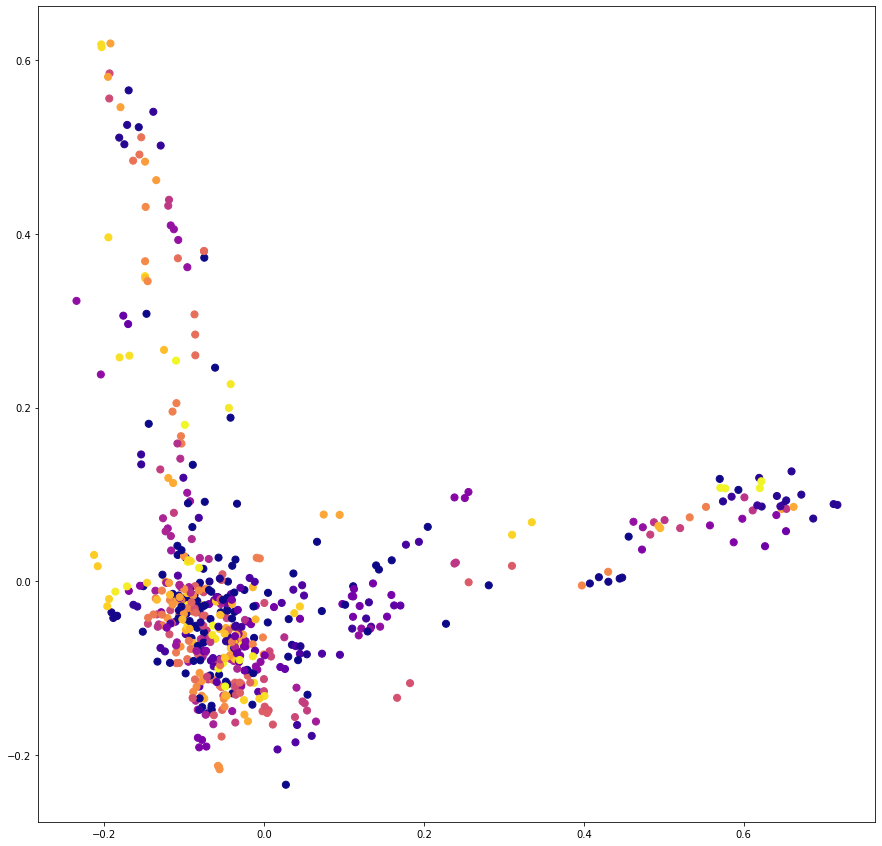

In [165]:
#plt.scatter(newdf['X0'],newdf['X1'],c=list, cmap='plasma')
plt.figure(figsize=(15,15))
plt.scatter(X_reduced[:,0],X_reduced[:,1], s=60, c=list, cmap='plasma')
plt.show()

## That is some messy clustering!

## Agglomerative Clustering

In [ ]:
agglom = AgglomerativeClustering(n_clusters=None, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None)
agglom.fit_predict(X)
print(agglom.labels_)
print(f"silhouette score = {silhouette_score(X, agglom.labels_)}")